In [3]:
import numpy as np
import matplotlib.pyplot as plt

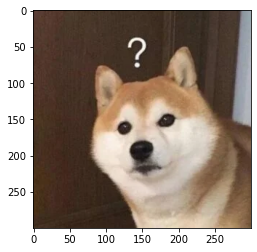

In [54]:
image = plt.imread("chai.png")
plt.imshow(image)
plt.show()

def transform(img):
    return (img - 0.5) * 2

def transform_reverse(img):
    return img / 2 + 0.5

image = transform(image)

In [45]:
def linear_schedule(time_steps, start=1e-4, end=0.02, ):
    return np.linspace(start, end, time_steps)

time_steps = 1000
betas = linear_schedule(time_steps)

In [46]:
#一步一步diffusion
# def q_sample_single_step(x, t):
#     noise = np.random.normal(0, 1, x.shape)
#     mean = np.sqrt(1-betas[t]) * x
#     var = betas[t]
#     return mean + np.sqrt(var) * noise
#
# def q_sample_step_by_step(x, t):
#     for i in range(t):
#         x = q_sample_single_step(x, i)
#     return x
#
# diffusion_img = q_sample_step_by_step(image, time_steps)
# plt.imshow(diffusion_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


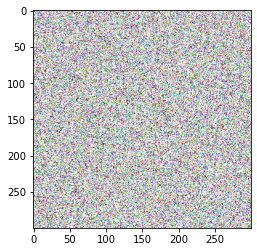

In [58]:
#直接diffusion
alphas = 1 - betas
alphas_cumprod = np.cumprod(alphas, axis=0)
alphas_cumprod_sqrt = np.sqrt(alphas_cumprod)
one_minus_alphas_cumprod_sqrt = np.sqrt(1 - alphas_cumprod)

def q_sample(x_0, t, noise=None):
    if noise is None:
        noise = np.random.normal(0, 1, x_0.shape)
    mean = alphas_cumprod_sqrt[t] * x_0
    std = one_minus_alphas_cumprod_sqrt[t]
    return mean + std * noise

diffusion_img = q_sample(image, time_steps - 1)
plt.imshow(transform_reverse(diffusion_img))

In [ ]:
sqrt_recip_alphas = np.sqrt(1. / alphas)
alphas_cumprod_prev = np.append(1., alphas_cumprod[:-1])
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)
log_posterior_variance = np.log(np.maximum(posterior_variance, 1e-20)) #数值稳定

In [ ]:
def p_sample(model, x, t):
    noise = np.random.randn(0, 1, x.shape) if t != 0 else np.zeros(x.shape)
    mean = sqrt_recip_alphas[t] * (x - betas[t] / one_minus_alphas_cumprod_sqrt[t] * model(x, t))
    logvar = log_posterior_variance[t]
    return mean + np.exp(0.5 * logvar) * noise

def p_sample_loop(model, shape, clip_denoised=False): # TODO
    """Sample from p_{theta} (x_{0:t-1} | x_t)"""
    x = np.random.normal(0, 1, shape)
    for i in reversed(range(time_steps)):
        x = p_sample(model, x, i)
    return x

In [ ]:
def p_loss(model, x_0, t):
    noise = np.random.randn(0, 1, x_0.shape)
    x_diffusion = q_sample(x_0, t, noise)
    predict_noise = model(x_diffusion, t)

    return np.mean((noise - predict_noise) ** 2)